<a href="https://colab.research.google.com/github/Ebadi-Fereshteh/Deep-Learning/blob/main/46-17-flowers/ResNet50V2/17_Flowers_ResNet50V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wandb

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense, AveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import wandb
from wandb.keras import WandbCallback
import cv2
import numpy as np
from tensorflow import keras
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.models import load_model

# Config wandb

In [3]:
wandb.init(project= "17-flowers")

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [4]:
config = wandb.config
# config.learning_rate = 0.0001

# Dataset

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
train_dataset_path = "/content/drive/MyDrive/datasets/Flowers/Train"
width = height = 224
batch_size= 32

idg = ImageDataGenerator(
    rescale= 1./255, 
    rotation_range= 10, 
    brightness_range= (0.8, 1.2), 
    shear_range=0.1, 
    zoom_range=0.1,
    horizontal_flip=True,     
    validation_split=0.2   
)

train_data = idg.flow_from_directory(
    train_dataset_path,
    target_size = (width, height),
    batch_size = batch_size,
    class_mode = "categorical",
    subset = "training"    

)

validation_data = idg.flow_from_directory(
    train_dataset_path,
    target_size = (width, height),
    batch_size = batch_size,
    class_mode = "categorical",
    subset = "validation"
)

Found 884 images belonging to 17 classes.
Found 204 images belonging to 17 classes.


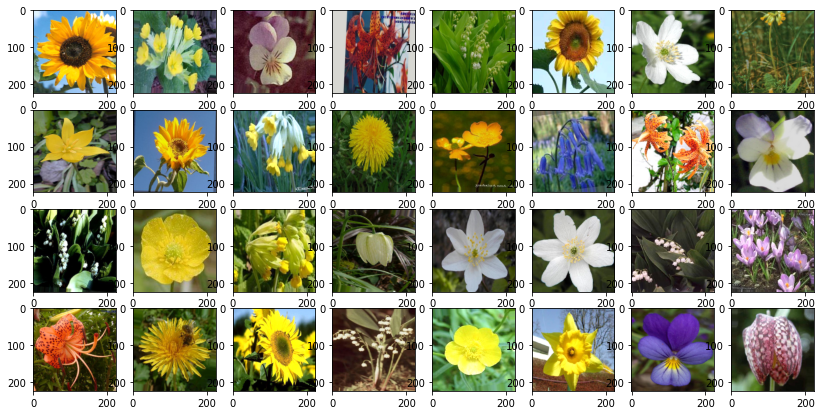

In [7]:
some_images = next(train_data)
X=some_images[0]
Y=some_images[1]

plt.figure(figsize=(14,7))
for i in range(32):
  plt.subplot(4,8,i+1)
  plt.imshow(X[i])

# Model

In [8]:
# customize base model
base_model = tf.keras.applications.ResNet50V2(
)
base_model.summary()


102883328/102869336 [==============================] - 4s 0us/step
Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                      

In [9]:
# customize base model
base_model = tf.keras.applications.ResNet50V2(
    include_top = False,
    input_shape = (width, height, 3),
    weights = "imagenet",
    pooling="avg"
)



94683136/94668760 [==============================] - 0s 0us/step


In [10]:
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

In [14]:
# freez Layer
for layer in base_model.layers:
    layer.trainable = False


In [15]:
model = tf.keras.models.Sequential([
    base_model,
    Dropout(0.2),
    Dense(17, activation='softmax')
])

In [16]:
model.compile( optimizer= tf.keras.optimizers.Adam(), 
              loss = tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

Callback save model (each epoch)

In [17]:
class CustomCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
        print("End epoch {} of training;".format(epoch))
        ep = "epoch_{}".format(epoch)
        dir = "/content/drive/MyDrive/models/17-flowers/17-flowers"
        name = "{}_{}.h5".format(dir, ep)
        print(name)
        model.save(name)

# Train

In [18]:
model_history = model.fit(train_data, validation_data= validation_data, epochs= 10, callbacks=[CustomCallback(), WandbCallback()])

Epoch 1/10
28/28 [==============================] - ETA: 0s - loss: 2.0814 - accuracy: 0.3643 End epoch 0 of training;
/content/drive/MyDrive/models/17-flowers/17-flowers_epoch_0.h5
28/28 [==============================] - 680s 24s/step - loss: 2.0814 - accuracy: 0.3643 - val_loss: 1.0258 - val_accuracy: 0.7157 - _timestamp: 1649419885.0000 - _runtime: 952.0000
Epoch 2/10
28/28 [==============================] - ETA: 0s - loss: 0.7894 - accuracy: 0.7839End epoch 1 of training;
/content/drive/MyDrive/models/17-flowers/17-flowers_epoch_1.h5
28/28 [==============================] - 163s 6s/step - loss: 0.7894 - accuracy: 0.7839 - val_loss: 0.6539 - val_accuracy: 0.8235 - _timestamp: 1649420053.0000 - _runtime: 1120.0000
Epoch 3/10
28/28 [==============================] - ETA: 0s - loss: 0.4840 - accuracy: 0.8857End epoch 2 of training;
/content/drive/MyDrive/models/17-flowers/17-flowers_epoch_2.h5
28/28 [==============================] - 163s 6s/step - loss: 0.4840 - accuracy: 0.8857 - va

In [19]:
model.save('/content/drive/MyDrive/models/17-flowers/46_17_flowers_ResNetV2.h5')

In [20]:
# select best model (best validation accuracy)

# model = load_model('/content/drive/MyDrive/models/17-flowers/17-flowers_epoch_15.h5')

In [21]:
# model = load_model('/content/drive/MyDrive/models/17-flowers/46_17_flowers_VGG16_2.h5')

# Test


In [22]:
test_dataset_path = "/content/drive/MyDrive/datasets/Flowers/Test"

width = height = 224
batchSize = 32

idg = ImageDataGenerator(
    rescale = 1./255
)

test_data = idg.flow_from_directory(
    test_dataset_path,
    target_size = (width, height),
    class_mode = "categorical",
    batch_size=batch_size,
)

Found 272 images belonging to 17 classes.


In [23]:
test_loss, test_acc= model.evaluate(test_data)
print(test_loss)
print(test_acc)

9/9 [==============================] - 151s 18s/step - loss: 0.5153 - accuracy: 0.8309
0.5152992010116577
0.8308823704719543


# Confusion matrix

[[ 6  0  0  0  0  0  1  6  0  0  0  0  0  3  0  0  0]
 [ 0 14  0  0  1  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0 15  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 15  0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  3  0  0 11  0  1  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 14  0  0  0  0  0  0  0  0  1  0  1]
 [ 0  0  0  1  0  0 13  2  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0 14  0  0  0  0  0  1  0  0  0]
 [ 0  2  0  0  0  0  0  0 14  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 16  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 16  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0 13  1  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  4 12  0  0  0  0]
 [ 0  0  0  0  0  0  0  2  0  0  0  0  0 14  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  3 13  0  0]
 [ 0  1  0  0  1  0  0  0  0  0  0  0  0  0  0 14  0]
 [ 0  1  0  0  0  0  0  1  0  0  0  0  0  0  0  0 14]]


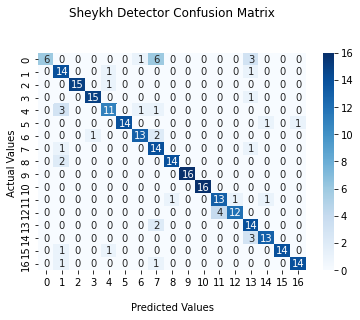

In [24]:
Y_pred = []

for path in test_data.filepaths:
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (width, height))
    image = image / 255
    image = image.reshape(1, width, height, 3)
    Y_pred.append(np.argmax(model.predict(image)))

cv_confMTX = confusion_matrix(test_data.classes, Y_pred)
print(cv_confMTX)

ax = sns.heatmap(cv_confMTX, annot=True, cmap='Blues')
ax.set_title('Sheykh Detector Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

plt.show()

# Inference

In [25]:
image_path = "/content/drive/MyDrive/datasets/Inference/flowers/01.jpg"

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # cv2 image color format !# tensorflow image color format
image = cv2.resize(image, (width, height))
image = image / 255
image = image.reshape(1, width, height, 3)
result = model.predict(image)
print(result)
pred = np.argmax(result)
print(pred)


[[1.7773236e-05 7.8289180e-05 1.1164993e-05 4.0194569e-05 4.6906897e-04
  5.9880534e-07 3.9738792e-05 9.0426529e-06 1.8564106e-05 5.4443916e-03
  9.8687452e-01 5.9766124e-04 1.5321503e-03 1.1540653e-05 1.9533229e-05
  3.4242156e-03 1.4114951e-03]]
10
